In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

### Mount the Google drive if needed

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy
    
os.chdir(os.path.join(basedir, 'neuralClosureModels'))

### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.helper_classes import * 
import src.solvers.neuralDDE_with_adjoint_accel as ndde
import src.advec_diff_case.advec_diff_eqn_modcall as adeq
from src.advec_diff_case.ROM_AD_Eqn_Helper_Classes import * 
import src.advec_diff_case.rom_advec_diff_modcall as rom

import time
import sys
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from shutil import move
import pickle

tf.keras.backend.set_floatx('float32')
import logging
tf.get_logger().setLevel(logging.ERROR)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Define some useful classes

### Class for user-defined arguments

In [4]:
class rom_ad_eq_nDDE_args(ndde.arguments, rom.rom_eqn_args):

    def __init__(self, batch_time = 12, batch_time_skip = 2, batch_size = 5, epochs = 500, learning_rate = 0.05, decay_rate = 0.95, test_freq = 1, plot_freq = 2, 
                 d_max = 1.1, rnn_nmax = 3, rnn_dt = 0.5, state_dim = 2, adj_data_size = 2,
                 model_dir = 'ROM_nODE_testcase/model_dir_test', restart = 0, val_percentage = 0.2,
                 T = 2., nt = 200, L = 1., nx = 100, Re = 250, u_bc_0 = 0., u_bc_L =0., rom_dims = 2, isplot = True, is_tstart_zero = True, 
                 ode_alg_name = 'dopri5', nsteps = 1): # add more arguments as needed
        
        ndde.arguments.__init__(self, data_size = nt, batch_time = batch_time, batch_time_skip = batch_time_skip, batch_size = batch_size, epochs = epochs,
                           learning_rate = learning_rate, decay_rate = decay_rate, test_freq = test_freq, plot_freq = plot_freq, d_max = d_max, rnn_nmax = rnn_nmax, 
                           rnn_dt = rnn_dt, state_dim = rom_dims, adj_data_size = rom_dims, model_dir = model_dir, restart = restart, val_percentage = val_percentage, isplot = isplot, is_tstart_zero = is_tstart_zero)

        rom.rom_eqn_args.__init__(self, T = T, nt = nt, L = L, nx = nx, Re = Re, u_bc_0 = u_bc_0, u_bc_L = u_bc_L, rom_dims = rom_dims, 
                              rom_batch_size = batch_size, ad_eq_batch_size = 1)
        
        self.rom_args_for_plot = rom.rom_eqn_args(T = T, nt = nt, L = L, nx = nx, Re = Re, u_bc_0 = u_bc_0, u_bc_L = u_bc_L, rom_dims = rom_dims, 
                              rom_batch_size = 1, ad_eq_batch_size = 1)
        
        self.ode_alg_name = ode_alg_name
        self.nsteps = nsteps

### Define the neural net architecture

In [5]:
class DDEFuncMain(tf.keras.Model):

    def __init__(self, args, **kwargs):
        super(DDEFuncMain, self).__init__(**kwargs)
        
        self.x1 = tf.keras.layers.Dense(5, activation='tanh',
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.x2 = tf.keras.layers.Dense(5, activation='tanh',
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.x3 = tf.keras.layers.Dense(5, activation='tanh',
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.x4 = tf.keras.layers.Dense(5, activation='tanh',
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.x5 = tf.keras.layers.Dense(5, activation='tanh',
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.out = tf.keras.layers.Dense(args.state_dim, activation='linear',
                                        kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.1), use_bias=True)
        
        self.args = args


    @tf.function
    def pass_layers(self, y_nn):
        
        for i in range(len(self.layers)):
            y_nn = self.layers[i](y_nn)
            
        return y_nn
    
    def call(self, y_nn):
        
        y_nn = self.pass_layers(y_nn)
        
        return y_nn

In [6]:
class DiscDDEFunc(tf.keras.Model):

    def __init__(self, main, rom_model, args, **kwargs):
        super(DiscDDEFunc, self).__init__(**kwargs)
        
        self.main = main
        self.rom_model = rom_model
        self.args = args
        
    def process_input(self, y, t ,d):     
        input = y(t)
        
        return input

    def call_nn_part(self, input):
        dy_dt = self.main(input)
        return dy_dt
    
    def __call__(self, y, t ,d, t_start = np.array([0.])):
        
        y_nn = self.process_input(y, t, d)

        dy_dt = self.call_nn_part(y_nn) + self.rom_model(y, t, t_start)
        
        return dy_dt

### Define a custom loss function

### Define a custom plotting function

In [7]:
class custom_plot:

    def __init__(self, true_y, y_no_nn, t, args):
        self.true_y = true_y
        self.y_no_nn = y_no_nn
        self.t = t
        self.args = args
        self.colors = ['b', 'g', 'r', 'k', 'c', 'm']

    def plot(self, *pred_y):
        fig = plt.figure(figsize=(6, 4), facecolor='white')
        ax = fig.add_subplot(111)

        ax.cla()
        ax.set_title('Coefficients', fontsize=14)
        ax.set_xlabel('t', fontsize=14)
        ax.set_ylabel('$a_i$', fontsize=14)
        ax.set_xlim(min(self.t.numpy()), max(self.t.numpy()))
        ax.set_ylim(-1, 1.1)

        for i in range(self.args.rom_dims):
            ax.plot(self.t.numpy(), self.true_y.numpy()[:, 0, i], self.colors[i % self.args.rom_dims]+'-', label = 'True Coeff. '+str(i+1))
            ax.plot(self.t.numpy(), self.y_no_nn.numpy()[:, 0, i], self.colors[i % self.args.rom_dims]+'-.', label = 'POD-GP Coeff. '+str(i+1))
            ax.plot(self.t.numpy(), pred_y[0].numpy()[:, 0, i], self.colors[i % self.args.rom_dims]+'--', label = 'Learned Coeff. '+str(i+1))

        ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.show() 

### Initialize model related parameters

In [8]:
args = rom_ad_eq_nDDE_args(batch_time = 6, batch_time_skip = 2, batch_size = 2, epochs = 250, learning_rate = 0.075, 
                           decay_rate = 0.97, test_freq = 1, plot_freq = 2, d_max = 0.2, rnn_nmax = 1, rnn_dt = 0.1, 
                           model_dir = 'ROM_nODE_testcase_v3/model_dir_case1b', restart = 0, val_percentage = 2., 
                           T = 2.0, nt = 200, L = 1., nx = 100, Re = 1000, u_bc_0 = 0., u_bc_L =0., rom_dims = 3, 
                           ode_alg_name = 'dopri5', nsteps = 5)

In [9]:
testcase_dir = 'neuralClosureModels/testcases/AD_Eqn_ROM'
save_dir_obj = save_dir(args = args, basedir = basedir, testcase_dir = testcase_dir)

### Solve for the high resolution model

In [10]:
os.chdir(os.path.join(basedir, testcase_dir))

%run -i setup_extended

/home/abhinavgupta0110/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:1181: UserWarning: dopri5: larger nsteps is needed
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


FOM done!


## Main part starts here

### Make objects and define learning-rate schedule

In [11]:
rom_model = rom.rom_ad_eqn(um = u_mean, ui = ui, op = op, app = args)
func_main = DDEFuncMain(args)
func = DiscDDEFunc(func_main, rom_model, args)

### Plot training time

In [12]:
func.load_weights(tf.train.latest_checkpoint(save_dir_obj.checkpoint_dir))

## Plot for the whole time

In [13]:
pred_y = ddeinttf(func, ai_t0, tf.concat([t, val_t], axis=0), fargs=([args.rnn_nmax, args.rnn_dt],), alg_name = args.ode_alg_name, nsteps = args.nsteps)

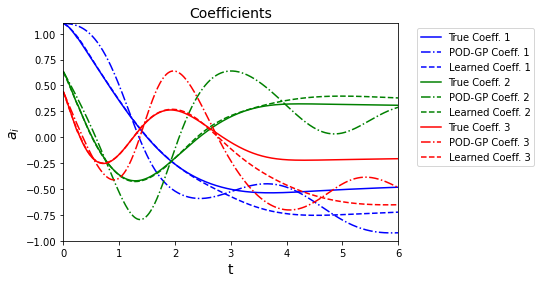

In [14]:
plot_obj = custom_plot(tf.concat([true_ai_red, val_true_ai_red], axis=0), ai_whole, tf.concat([t, val_t], axis=0), args)
plot_obj.plot(pred_y)

#### Save data for comparison

In [15]:
os.chdir(basedir)

data_dict = {'true_ai_red':true_ai_red, 'val_true_ai_red':val_true_ai_red,
             'ai':ai, 'val_ai':val_ai, 'pred_y': pred_y, 't': t, 'val_t': val_t}

with open(os.path.join('neuralClosureModels/final_paper_scripts', 'nODE_C1b_Exp1_predictions.pkl'), 'wb') as output:
    pickle.dump(data_dict, output, pickle.HIGHEST_PROTOCOL)

In [16]:
func_main.summary()

Model: "dde_func_main"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  20        
_________________________________________________________________
dense_1 (Dense)              multiple                  30        
_________________________________________________________________
dense_2 (Dense)              multiple                  30        
_________________________________________________________________
dense_3 (Dense)              multiple                  30        
_________________________________________________________________
dense_4 (Dense)              multiple                  30        
_________________________________________________________________
dense_5 (Dense)              multiple                  18        
Total params: 158
Trainable params: 158
Non-trainable params: 0
_______________________________________________________